In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(palette='Set1')
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

from sklearn import datasets
from sklearn import metrics

### Lasso modelling function with Train-Test split and Grid Search for optimal Alpha

 - Lasso may exclude variables from the model entirely where appropriate, making it simpler and more interpretable.

In [2]:
def model(df, features, target):
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.25,
                                                        random_state=42)

    grid = GridSearchCV(estimator=Lasso(),
                        param_grid={'alpha': np.logspace(-10, 10, 21)},
                        scoring='neg_mean_squared_error',
                        return_train_score=True,
                        cv=10, 
                       iid=True)

    grid.fit(X_train,y_train)    
    best_model = grid.best_estimator_
    

    y_pred_mean = [y_train.mean()] * len(y_test)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, best_model.predict(X_train))),2)
    rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, best_model.predict(X_test))),2)
    rmse_baseline = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean)),2)
    
    line = [features, rmse_train, rmse_test, rmse_baseline, best_model.intercept_, best_model.coef_]
    return line

#### Import dataset

In [3]:
df = pd.read_csv('data/daily.csv')

#### Create additional columns
- Dusk Hour could capture both the increase in daylight hours and the change to BST in summer.
- Dusk Hour and Relative Humidity have minimum values well above zero so the linear regression may be improved by using values relative to the mean.

In [4]:
df['Dusk_Hour'] = pd.to_datetime(df['Dark']).dt.hour + (pd.to_datetime(df['Dark']).dt.minute / 60)
df['Rel_Dusk_Hour'] = df['Dusk_Hour'] - df['Dusk_Hour'].mean()
df['Rel_Rel_Humidity'] = df['Rel_Humidity'] - df['Rel_Humidity'].mean()

#### Further columns after seeing where models based on 2013-2017 data performed poorly for 2018
- Hottest summer on record; linear fit for temperature may not be appropriate
- Introduction of dockless bikes meaning TfL no longer has a monopoly on hire bikes

In [5]:
def too_hot(temp):
    if temp > 20:
        x = temp - 20
    else:
        x = 0    
    return x

def too_cold(temp):
    if temp < 1:
        x = 1 - temp
    else:
        x = 0    
    return x

df['Hot'] = df['Temp'].apply(too_hot)
df['Cold'] = df['Temp'].apply(too_cold)

df['Comp_bikes_Share'] = df['Comp_bikes'] / (df['Comp_bikes'] + df['Bicycles'])

#### Model test data and features specified below
- Currently a somewhat manual process to run the model on different time periods and with different features
- I intend to create interactive controls for these and provide the ability to run multiple scenarios at the same time

In [6]:
dfm = df[(df['Year']>=2013) & (df['Year']<=2018)].dropna().copy()
lt = ['Wkend_or_Hol','School_Hol','Rel_Dusk_Hour']
st = lt + ['Rel_Rel_Humidity','Temp']
st2 = st +['Hot','Cold','Comp_bikes_Share']
target = 'hpb'

In [7]:
modeldf = pd.DataFrame(columns=['Features','Train','Test','Baseline','Intercept','Coefficients'])
for f in [lt,st2]:    
    x = model(dfm, f, target)
    modeldf.loc[len(modeldf)] = x

In [8]:
display(modeldf)

,Features,Train,Test,Baseline,Intercept,Coefficients
0,"[Wkend_or_Hol, School_Hol, Rel_Dusk_Hour]",0.59,0.60,0.87,2.744730,"[-0.5621497747074337, -0.07679696466113876, 0...."
1,"[Wkend_or_Hol, School_Hol, Rel_Dusk_Hour, Rel_...",0.44,0.44,0.87,1.750399,"[-0.5390934225456465, -0.15610227639902005, 0...."


In [9]:
ff = modeldf[['Features','Intercept','Coefficients']]

In [10]:
display(ff['Coefficients'][0])
display(ff['Coefficients'][1])

array([-0.56214977, -0.07679696,  0.2696969 ])

array([-0.53909342, -0.15610228,  0.02893156, -0.02706806,  0.08783616,
       -0.08131615,  0.23703548, -1.37143588])

- Minor variations in the date range or train-test split can result in similar accuracy but arrived at in quite different ways (for example, a negative intercept with a large positive value for the 'Relative Dusk Hour' coefficient vs a positive intercept with a much smaller value for this co-efficient)
- Known weather conditions improve the model significantly, and it is often such that Relative Dusk Hour is then excluded altogether.
- The addition of competitor market share helps for prediction of more recent TfL hire values. 

In [11]:
def predict(df, model, name):
    
    featlist, cos, intercept = list(ff.iloc[model]['Features']), list(ff.iloc[model]['Coefficients']),ff.iloc[model]['Intercept']
    coeffs = dict(zip(featlist, cos))
    preds = []
    for row in df.itertuples():
        comps = []
        for i in featlist:
            col = df.columns.get_loc(i) + 1
            comp = coeffs[i] * row[col]
            comps.append(comp)
        pred = sum(comps) + intercept    
        preds.append(pred)
    pred_col_name = name

    df[pred_col_name] = preds

#### Specify time period to plot predicted values for on graph

In [12]:
dfp = df[(df['Year']==2018) & (df['Month'] >=4) & (df['Month']<= 5)].reset_index(drop=True)

In [13]:
m = ['Long-term model','Short-term model']
for i in range(len(m)):
    mod = i
    name = m[i]
    predict(dfp, mod, name)

In [14]:
dfp = dfp.dropna(subset=['Hires'])
filter_col = [col for col in dfp if 'model' in col or col in ('Date','hpb')]

mods = dfp[filter_col].copy()
mods = mods.rename(columns={'hpb':'Actual hires per bike'})

gph = pd.melt(mods, id_vars=['Date'], var_name='Model', value_name='Hires per bike')
gph['Day of Year'] = pd.to_datetime(gph['Date']).dt.dayofyear

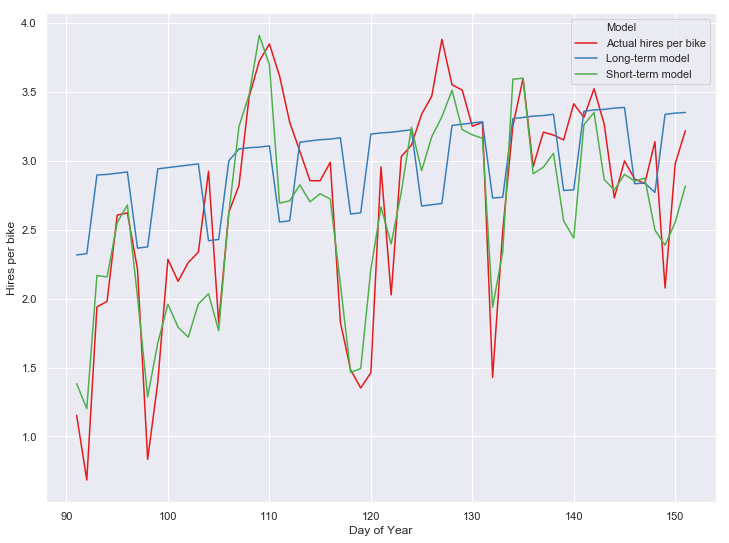

In [15]:
plt.figure(figsize=(12,9))
g = sns.lineplot(x='Day of Year', y='Hires per bike', hue='Model', data=gph)

- Given that the weather data used here is based on daily averages, the model may struggle on days where weather was variable, because of the significant spikes in demand for bikes during the morning and afternoon rush hours.